# Twitter Sentiment Analysis: The Rise (or Fall) of Andrew Tate

Overview:
We're going to analyze people's perception of Andrew Tate on twitter with positive sentiment represented with label '1' and negative sentiment represented with label '0'. We use Logistic Regression algorithm to classify each tweets

Training Dataset Source: https://www.coursera.org/projects/twitter-sentiment-analysis

Testing dataset to get insight about Andrew Tate from Twitter API


# Step 1: IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the data
df = pd.read_csv('twitter.csv')

As we can see from the result below, the data is imbalanced. There are way more positive labeled tweets in comparison to the negatively labeled

In [3]:
# seeing the number of negative and positive labeled data
print("The shape of negative labeled tweets: ")
print(df[df['label']== 1].shape)
print("The shape of positive labeled tweets: ")
print(df[df['label'] == 0].shape)

The shape of negative labeled tweets: 
(2242, 3)
The shape of positive labeled tweets: 
(29720, 3)


To prevent the bias towards positive labeling, we're sampling the positive labeled tweet to match the amount of the negative labeled tweets, 2242 tweets for each labels

In [4]:
df_label_one = df[df['label']==1]
df_label_one

df_label_zero = df[df['label']==0]
df_label_zero.drop(df_label_zero.index[2242:], axis=0, inplace=True)
df_label_zero

frames_1 = [df_label_zero, df_label_one]
pd.set_option('display.max_rows', 10)
tweets_df= pd.concat(frames_1, ignore_index = True)

C:\Users\Reinhart\AppData\Local\Temp\ipykernel_8252\3220590225.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label_zero.drop(df_label_zero.index[2242:], axis=0, inplace=True)


In [5]:
print(df_label_one.shape)
print(df_label_zero.shape)

(2242, 3)
(2242, 3)


In [6]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4484 entries, 0 to 4483
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4484 non-null   int64 
 1   label   4484 non-null   int64 
 2   tweet   4484 non-null   object
dtypes: int64(2), object(1)
memory usage: 105.2+ KB


In [7]:
tweets_df.describe()
tweets_df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
4479,31935,1,lady banned from kentucky mall. @user #jcpenn...
4480,31947,1,@user omfg i'm offended! i'm a mailbox and i'...
4481,31948,1,@user @user you don't have the balls to hashta...
4482,31949,1,"makes you ask yourself, who am i? then am i a..."


In [8]:
# Drop the 'id' column
tweets_df = tweets_df.drop(['id'], axis=1)
tweets_df

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
4479,1,lady banned from kentucky mall. @user #jcpenn...
4480,1,@user omfg i'm offended! i'm a mailbox and i'...
4481,1,@user @user you don't have the balls to hashta...
4482,1,"makes you ask yourself, who am i? then am i a..."


# Step 2: Importing data from Twitter API

In [9]:
from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

from textblob import TextBlob
import re


In [10]:
# For twitter API credentials
class Credentials():
  def __init__(self, access_token, access_token_secret, consumer_key, consumer_secret):
    self.ACCESS_TOKEN = access_token
    self.ACCESS_TOKEN_SECRET = access_token_secret
    self.CONSUMER_KEY = consumer_key
    self.CONSUMER_SECRET = consumer_secret
ACCESS_TOKEN = "1153291455340765184-AH0fD3WMlIOmdChkVMmAtWV18zD8OE"
ACCESS_TOKEN_SECRET = "b8QtThweLDp0hGEiawIqRxFZAtCKILpCh3keWcft56AO4"
CONSUMER_KEY = "i9UvhwXbvVxWCI6ymXb6gUuSv"
CONSUMER_SECRET = "fRAzewVdYvjDt2edPh8EhCZMVBniTMKCtNaSqpELa9Ka63IQr8"
twitter_credentials = Credentials(ACCESS_TOKEN, ACCESS_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET)

#To Authenticate the access to twitter API
class TwitterAuthenticator():
    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user
    def get_twitter_client_api(self):
      return self.twitter_client

#To convert the JSON data to pandas dataframe
class TweetAnalyzer():

    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweet'])

        return df



We then combine the data from the dataset and the twitter API into df_all dataframe. This is important to ensure equal number of features for both dataset

In [11]:
twitter_client = TwitterClient()
tweet_analyzer = TweetAnalyzer()
api = twitter_client.get_twitter_client_api()
tweets = api.search(q = "\"andrew tate\" lang:en until:2022-10-08 since:2022-09-01 -filter:links", count=100)
df_tate = tweet_analyzer.tweets_to_data_frame(tweets)


The data from twitter API is not labeled. Therefore, for the sake of dataset completeness to make it possible to combine both dataframe, we assign all tweets with label '1'. This doesnt matter because the label won't be used as an input to the classifier model. It's done with the code below:

In [12]:
one_label = [1 for i in range(100)]
df_tate['label'] = one_label #assigning all tweets with label '1'

# Combining model and testing dataset
frames = [tweets_df, df_tate]
pd.set_option('display.max_rows', 10)
df_all= pd.concat(frames, ignore_index = True)
df_all

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
4579,1,Piers Morgan &amp; Andrew Tate converse. Enter...
4580,1,"@emilyhewertson Putin, Piers Morgan, Jeremy Co..."
4581,1,RT @SheerOpulence2: @RockiiiiRoadd I feel like...
4582,1,@RyanGellatly Mario - Still Captain Lou\nLuigi...


# Step 3: Removing Punctuations and Stopwords

To ensure the value of each data, both the punctuations and stopwords will be removed

In [13]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Reinhart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:

# Remove Punctuation and Stopwords
def message_cleaning(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return Test_punc_removed_join_clean

In [15]:
# Trying the function
df_all_cleaned = df_all['tweet'].apply(message_cleaning)

In [16]:
print(df_all_cleaned.iloc[-10]) # show the cleaned up version

['RT', 'Limonadaman', 'think', 'Andrew', 'Tate', 'bought', 'NFT', 'Curious']


In [17]:
print(df_all.iloc[-10]['tweet']) # show the original version

RT @Limonadaman: You think Andrew Tate has bought an NFT? Curious.


In [18]:
df_all['tweet'] = df_all_cleaned

# Step 4: Performing Vectorization

To ensure model fitting can happen, we convert the tweet data into vectors through vectorization

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = message_cleaning, dtype = np.uint8)
tweets_countvectorizer = vectorizer.fit_transform(df_all['tweet'])
X_all = pd.DataFrame(tweets_countvectorizer.toarray())
print(X_all)

      0     1     2     3     4     5     6     7     8     9     ...  4227  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
4579     0     0     0     0     0     0     0     0     0     0  ...     0   
4580     0     0     0     0     0     0     0     0     0     0  ...     0   
4581     0     0     0     0     0     0     0     0     0     0  ...     0   
4582     0     0     0     0     0     0     0     0     0     0  ...     0   
4583     0     0     0     0     0     0     0     0     0     0  ...     0   

      4228  4229  4230  4231  4232  4233  4234  423

# Step 5: Train and Evaluate Logistic Regression Model

In [20]:
# We exclude the last 100 data since it contains the Andrew Tate tweets that we're going to analyze
# We dont want the training model to access testing data
X_modeling = X_all[:-100]
y_modeling = df_all.iloc[:-100]['label']


In [21]:
#splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_modeling, y_modeling, test_size=0.2)


              precision    recall  f1-score   support

           0       0.56      1.00      0.72       475
           1       1.00      0.11      0.20       422

    accuracy                           0.58       897
   macro avg       0.78      0.56      0.46       897
weighted avg       0.77      0.58      0.48       897



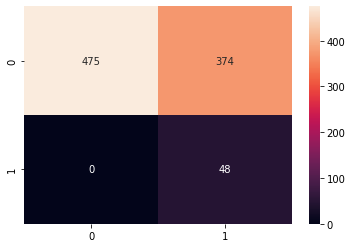

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Applying Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


#Generating confusion Matrix and classification report
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot = True, fmt = 'g')

print(classification_report(y_test, y_pred))

#Step 5: Applying the model to Andrew Tate related tweets

In [23]:
#Testing the model on Andrew Tate tweets
y_predict_tate = model.predict(X_all[-100:])
df_all.iloc[-100:]['label'] = y_predict_tate
df_tate = df_all.iloc[-100:]
y_predict_tate

C:\Users\Reinhart\AppData\Local\Temp\ipykernel_8252\4263689131.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all.iloc[-100:]['label'] = y_predict_tate


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)